# Modeling Lithium Intercalation of a Single Spinel Particle under Potentiodynamic Control

## About

- authors:
    - Dong Zhang
    - Branko N. Popov
    - Ralph E. White
- id:
    ``doi: 10.1149/1.1393279``
- tags:
    - micro
    - spm
- sources:
    - [paper](https://iopscience.iop.org/article/10.1149/1.1393279)

This paper is one of the fundamental papers of single particle based battery modeling.
In this paper a particle of a single halfcell is simulated.
With only one differential equations it is one of the simplest models to start with.

Implementing the model of the paper seems straight forward, but comes with some pitfalls which have been addressed by this implementation.
The paper introduces the unitless concentration $y$, which at the beginning of the simulation (intial condition) is $=1$.
But the function of the open-circuit potential $U_{ocp}$ is singluar for $y$-values greater or equal to $y_{max} = 0.998432$.
This implementions goes arround the problem by using a linear function for $y >= y_{max}$  (Taylor expension).
Nevertheless $y$-values equal to 1 are still a problem, because the ion flux $j$ will be always zero.

## Materialdata

In [62]:
import numpy as np

const = {
    "R": 8.314472,    # [m^2 kg s^-2 K^-1 mol^-1]
    "F":96485.3415,   # [m^2 kg s^-2 K^-1 mol^-1]
    "T":25 + 273.15,  # [°C] -> [K]
    "dU/dt": 1 * 1e-3    # "nu" [mV s^-1] -> [V s^-1]
}

electrode = {
    "D": 2.2e-9 * 1e-4, # [cm^2 s^-1] -> [m^2 s^-1]
    "Rs": 5e-4 * 1e-2, # [cm] -> [m]
    "c_ini": 23.7 * 1e3, # [mol dm^-3] -> [mol m^-3]
    "c_max": 23.7 * 1e3, # [mol dm^-3] -> [mol m^-3]
    "k": 0.00019 * np.power(1e-2, (5 / 2)), # [cm^(5/2) s^-1 mol^(-1/2)] -> [m^(5/2) s^-1 mol^(-1/2)]
    "beta": 0.5, # []
}

electrolyte = {
    # "c_ini": 1.0 * 1e3, # [mol dm^-3] -> [mol m^-3]
    "c_max": 1.0 * 1e3, # [mol dm^-3] -> [mol m^-3]
}

electrode["c_ini"] *= (1 - 1e-4) # adding imperfection

The imperfection of the intiial concentration of the electrode is required, due to the Volmer-Butler-Equation beeing zero in this case no matter the current over-potential.

## Open-Circuit-Potential (OCP)

In [2]:
def U_ocp(y_s):
    """
    The open-circuit potential as a function of the dimensionaless
    concentration of lithium-ions at the surface of the manganese dioxide particle
    """
    y_s_max = 0.998432
    return (
        4.19829
        + 0.0565661 * np.tanh(-14.5546 * y_s + 8.60942)
        - 0.0275479 * (np.power(abs(y_s_max - y_s), -0.492465) - 1.90111)
        - 0.157123 * np.exp(-0.04738 * np.power(y_s, 8))
        + 0.810239 * np.exp(-40.0 * y_s + 5.355)
    )

For numerical stability it is important to have a function which is defined for values greater $\mathrm{y_{max}}$.
Therefore, a linear expansion for values close to $\mathrm{y_{max}}$ was added (see: ``U_ocp_ext(y_s)``)

In [3]:
def U_ocp_ext(y_s, dy=0.006360215613507735):  # 22e-4
    y_s_max = 0.998432
    if y_s >= y_s_max - dy:
        c = y_s_max - dy
        h = 1e-6
        U_ocp_max = U_ocp(y_s_max - dy)
        U_ocp_max_h = U_ocp(y_s_max - dy - h)
        return U_ocp_max + (U_ocp_max - U_ocp_max_h) / (h) * (y_s - c)
    return U_ocp(y_s)

### (Optional) Optical Comparison

Both open-circuit potentials are plotted.
This is helpful for debugging and illustrating purposes.

In [4]:
x_min = 0.18
x_break = 0.998431 # litte bit les then y_s_max
x_max = 1.0

y_paper = np.linspace(x_min, x_break, 1000)
U_paper = np.zeros(len(y_paper))
for i in range(len(y_paper)):
    U_paper[i] = U_ocp(y_paper[i])

y_ext = np.linspace(x_break, x_max, 10)
U_ext = np.zeros(len(y_ext))
for i in range(len(y_ext)):
    U_ext[i] = U_ocp_ext(y_ext[i])

import uocps
y_plett = np.linspace(x_min, x_max-1/1000, 1000)
U_plett = np.zeros(len(y_plett))
for i in range(len(y_plett)):
    U_plett[i] = uocps.U_ocp("LMO",y_plett[i])


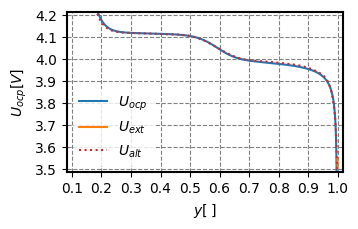

In [5]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from helpers import set_size


fig,ax = plt.subplots(figsize=set_size(245))

ax.plot(y_paper, U_paper, label=r"$U_{ocp}$")
ax.plot(y_ext, U_ext, label=r"$U_{ext}$")
ax.plot(y_plett, U_plett, label=r"$U_{alt}$", linestyle='dotted', color="#d62728")

ax.xaxis.grid(which='both', color='gray', linestyle='dashed')
ax.yaxis.grid(color='gray', linestyle='dashed')

ax.set_xlabel(r"$y \left[ \; \right]$")
ax.set_ylabel(r"$U_{ocp} \left[ V \right]$")
ax.legend(loc='lower left', 
          edgecolor='white',
          fancybox=False, frameon=True)


x_min = np.floor(0.1 * 10) / 10
x_max = np.ceil(1.0 * 10) / 10
dx = x_max - x_min

minor_locator = AutoMinorLocator(1)
ax.xaxis.set_minor_locator(minor_locator)
ax.set_xticks(np.arange(x_min, x_max + 0.1,0.1))
ax.set_xlim([x_min - dx * 0.02, x_max + dx * 0.02])

y_min = 3.5
y_max = 4.2
dy = y_max - y_min
ax.set_yticks(np.arange(y_min, y_max + 0.1, 0.1))
ax.set_ylim([y_min - dy * 0.02, y_max + dy * 0.02])

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_color('black')  
    ax.spines[axis].set_linewidth(1.5)  

# This should be called after all axes have been added
fig.tight_layout(pad=0)
plt.show()

## Applied Potential

An external potential is applied to the halfcell.
The potential starts with the potential of the fully charged cell and discharges the battery by increasing the potential with a constant value over time.
After a short holding period, this process is reversed.

In [6]:
y_max = electrode["c_ini"]/ electrode["c_max"]
U_start = U_ocp_ext(y_max) 
U_max = 4.3102  # [V]
t_change = (U_max-U_start) / const["dU/dt"]
t_hold = t_change *0.1
t_period = 2*(t_change + t_hold)
t_end = (
        t_change # discharge
        + t_hold 
        + t_change  # charge
    )

def U_app(t):
    t_rel = t % t_period
    if t_rel <= t_change:
        return U_start + t_rel * const["dU/dt"]
    elif t_rel - t_change <= t_hold:
        return U_max
    elif t_rel - (t_change + t_hold) <= t_change:
        return U_max - (t_rel - t_change - t_hold) * const["dU/dt"]
    else:
        return U_start

### (Optional) The Applied Voltage Curve

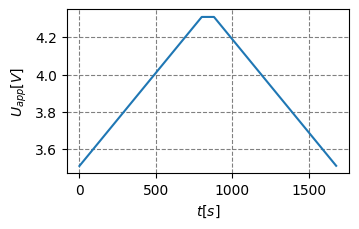

In [8]:

ts = np.arange(t_end)
u_apps = [U_app(t) for t in ts]

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from helpers import set_size


fig,ax = plt.subplots(figsize=set_size(245))

ax.plot(ts, u_apps, label=r"$U_{app}$")

ax.xaxis.grid(which='both', color='gray', linestyle='dashed')
ax.yaxis.grid(color='gray', linestyle='dashed')

ax.set_xlabel(r"$t \left[ s \right]$")
ax.set_ylabel(r"$U_{app} \left[ V \right]$")

fig.tight_layout(pad=0)
plt.show()

## Butler-Volmer-Equation

The Butler-Volmer-Equation can be used to describe the ion flux over the particle surface.

In [9]:
def j_eta(c_surf:float, eta:float):
    """_summary_

    Parameters
    ----------
    c_surf : float
        concentration on particle surface [mol/m^3]

    eta : float
        over potential [V]

    Returns
    -------
    float
        ion flux in [A/m^2]/[A*s/mol] = [mol/m^2/s]
    """
    j0 = (
        electrode["k"] 
        * np.power(electrolyte["c_max"], 1 - electrode["beta"]) 
        * np.power(electrode["c_max"] - c_surf, 1 - electrode["beta"]) 
        * np.power(c_surf, electrode["beta"])
    )

    j = j0 * (
        np.exp(((1 - electrode["beta"]) * const["F"] * eta) / (const["R"] * const["T"]))
        - np.exp(-1 * (electrode["beta"] * const["F"] * eta) / (const["R"] * const["T"]))
    )

    return j

The overpotential can be simplified with:
$$\eta = U_app(t) - U_{ocp}(c_{surf}).$$
Resulting in ``ion_flux(c_surf, u_app)``

In [10]:
def ion_flux(c_surf: float, u_app: float):
    eta = u_app - U_ocp_ext(c_surf / electrode["c_max"])
    return j_eta(c_surf, eta)

## FEM

In [11]:
from skfem import MeshLine

n_nodes = 20 + 1
space = np.linspace(0, 1, n_nodes)
mesh = MeshLine(space).with_boundaries(
    {"inner": lambda xi: xi[0] == 0, "surface": lambda xi: xi[0] == 1.0}
)

In [12]:
from skfem import Basis, ElementLineP2

basis = Basis(mesh, ElementLineP2())  # ElementLineHermite
basis_surf = basis.boundary("surface")

In [13]:
from skfem import  BilinearForm, LinearForm
from skfem.helpers import dot, grad

@BilinearForm
def M(c, v, w):
    r = w.x[0]
    return r**2 * electrode["Rs"] * c * v


@BilinearForm
def A(c, v, w):
    r = w.x[0]
    return electrode["D"] * r**2 / electrode["Rs"] * dot(grad(c), grad(v))


@LinearForm
def b(v, w):
    return dot(w.n, v)

In [14]:
Mass = M.assemble(basis)
Fick = A.assemble(basis)
bc = b.assemble(basis_surf)

In [15]:
Mass_inv = np.linalg.pinv(Mass.toarray())

In [16]:
def get_c_surf(us):
    return us[basis.get_dofs("surface")]

In [17]:
def sort_u_by_x(basis, u):
    x_coords = basis.doflocs[0] # [0, 1, 0.25, 0.5, 0.75]
    indeces = [i for i in range(len(x_coords))] # [0, 1, 2, 3, 4]
    indeces_by_x = [id for _,id in sorted(zip(x_coords, indeces))] # [0, 4, 1, 2, 3]
    x_sorted = np.sort(x_coords) # [0, 0.25, 0.5, 0.75, 1]
    res = [u[i] for i in indeces_by_x] # [u_0, u_0.25, u_0.5, u_0.75, u_1]
    return (x_sorted, res)

## Problem

setting the intial values

In [18]:
def inital(x):
    return np.ones((x.shape[1], x.shape[2])) * electrode["c_ini"]

u0 = basis.project(inital)

To solve the problem the solver requires the problem to be written in the following form:
$$func(t, u) \mapsto \frac{\partial u}{ \partial t}.$$
For the problem from Zhang et. al. the $u = c$.
As mentioned earlier the Problem written in FEM looks like:
$$M.\frac{\partial c}{ \partial t} = -j * bc - F.c,$$
with $M$-the mass matrix, $F$- the diffusion matrix derived from Fick's law and $bc$- the vector of the Neumann boundary condition on the surface.
To get the required form one has to simply multiply with the inverse of $M$:
$$\frac{\partial c}{ \partial t} = M^{-1}.(-j * bc - F.c)$$
and the problem is finished.



In [19]:
def zhang(t, u):
    j = ion_flux(get_c_surf(u), U_app(t))
    return np.matmul(Mass_inv, (-j * bc - Fick.dot(u)))

## Solve

In [55]:
from scipy.integrate import solve_ivp

tspan = [0.0, t_end]

sol = solve_ivp(
    zhang,
    tspan,
    u0,
    method="Radau",  # Radau, BDF, LSODA
    # atol=1e-6,
    dense_output=True,
)

/tmp/ipykernel_13555/577979725.py:5: RuntimeWarning: invalid value encountered in power
  * np.power(electrode["c_max"] - c_surf, 1 - electrode["beta"])


## Solution

In [71]:
import numpy as np


ts = np.linspace(0, t_end, 2000)
c_sol = sol.sol(ts).T

u_apps = np.zeros(len(ts))
js = np.zeros(len(ts))

for i in range(len(ts)):
    u_apps[i] = U_app(ts[i])
    c_li = c_sol[i]
    c_surf = get_c_surf(c_li)
    js[i] = ion_flux(c_surf, u_apps[i])

js = js * (electrode["Rs"] / (electrode["D"] * electrode["c_max"])) # dimensionless j []

### Plotting j(U_app)

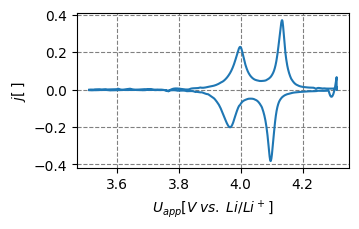

In [72]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from helpers import set_size

fig,ax = plt.subplots(figsize=set_size(245))

ax.plot(u_apps, js)

ax.xaxis.grid(which='both', color='gray', linestyle='dashed')
ax.yaxis.grid(color='gray', linestyle='dashed')

ax.set_xlabel(r"$U_{app} \left[ V \; vs. \; Li/Li^+\right]$")
ax.set_ylabel(r"$j \left[ \; \right]$")

fig.tight_layout(pad=0)

plt.show()

## Animating c_Li(x, t)

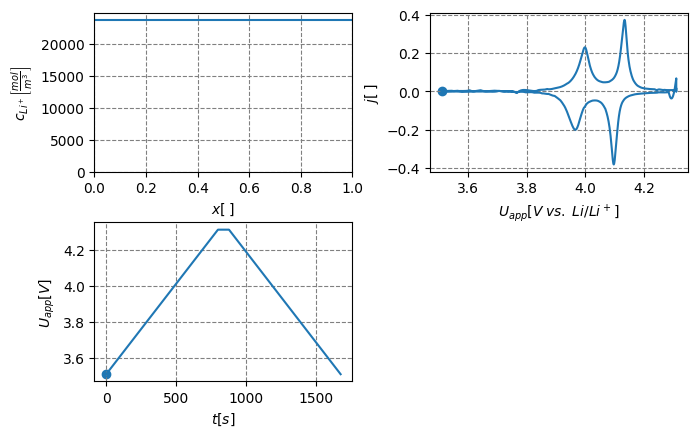

In [76]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from helpers import set_size


time_scale = 4
fig,ax = plt.subplots(2,2, figsize=set_size(490))

xs, ys = sort_u_by_x(basis,c_sol[0])
line_c = ax[0,0].plot(xs, ys)[0]
scat_j = ax[0,1].scatter(u_apps[0], js[0])
scat_U = ax[1,0].scatter(ts[0], u_apps[0])

# Axis
img = ax[0,0]
img.xaxis.grid(which='both', color='gray', linestyle='dashed')
img.yaxis.grid(color='gray', linestyle='dashed')

img.set_xlabel(r"$x \left[ \; \right]$")
img.set_ylabel(r"$c_{Li^+} \left[ \frac{mol}{m^3} \right]$")
img.set(xlim=[0, 1], ylim=[0.0*electrode["c_max"], 1.05*electrode["c_max"]])

# j(U_app)
img = ax[0,1]
img.plot(u_apps, js)
img.xaxis.grid(which='both', color='gray', linestyle='dashed')
img.yaxis.grid(color='gray', linestyle='dashed')

img.set_xlabel(r"$U_{app} \left[ V \; vs. \; Li/Li^+\right]$")
img.set_ylabel(r"$j \left[ \; \right]$")

# U_app(t)
img = ax[1,0]
img.plot(ts, u_apps, label=r"$U_{app}$")

img.xaxis.grid(which='both', color='gray', linestyle='dashed')
img.yaxis.grid(color='gray', linestyle='dashed')

img.set_xlabel(r"$t \left[ s \right]$")
img.set_ylabel(r"$U_{app} \left[ V \right]$")


img = ax[1,1]
img.axis('off')

fig.tight_layout(pad=0)

def update(frame):
    frame_id = int(frame * time_scale)
    t = ts[frame_id]
    xs, ys = sort_u_by_x(basis,c_sol[frame_id])
    line_c.set_ydata(ys)
    scat_j.set_offsets([u_apps[frame_id], js[frame_id]])
    scat_U.set_offsets([ts[frame_id], u_apps[frame_id]])
    return line_c, scat_j, scat_U

import matplotlib.animation as animation
ani = animation.FuncAnimation(fig=fig, func=update, frames=int(len(ts)/time_scale), interval=30)
ani.save(filename="sol_zhang.mp4", writer="ffmpeg")

from IPython.display import HTML
HTML(ani.to_html5_video())